In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
global_metadata = pd.read_csv('../../src/nlp/topic_modeling/global_metadata.csv')

In [3]:
community_topic_counts = global_metadata.groupby(['community_id', 'topic', 'topic_id']).size().reset_index(name='count')

# Compouting each tipic percentage in each community
community_totals = community_topic_counts.groupby('community_id')['count'].transform('sum')
community_topic_counts['percent'] = community_topic_counts['count'] / community_totals

community_topic_counts.head()

,community_id,topic,topic_id,count,percent
0,0.0,-1_trump_government_political_congress,-1,1052,0.042009
1,0.0,0_political_republicans_government_democrats,0,23126,0.923489
2,0.0,100_democrats_trump_partisan_impeaching,100,3,0.000120
3,0.0,101_news_group_mental_believe,101,4,0.000160
4,0.0,102_anti_euthanasia_complying_deprivation,102,4,0.000160


In [4]:
community_type_topics = global_metadata.groupby(['community_type', 'topic', 'topic_id']).size().reset_index(name='count')

# Compouting each tipic percentage in each community
community_totals = community_type_topics.groupby('community_type')['count'].transform('sum')
community_type_topics['percent'] = community_type_topics['count'] / community_totals

# # Retrieving the dominant topic for each community
# dominant_topics = community_type_topics.groupby('community_type').apply(
#     lambda x: x.loc[x['count'].idxmax()]
# )
# dominant_topics
community_type_topics.head()

,community_type,topic,topic_id,count,percent
0,Noisy community,-1_trump_government_political_congress,-1,509,0.039302
1,Noisy community,0_political_republicans_government_democrats,0,11691,0.902710
2,Noisy community,101_news_group_mental_believe,101,1,0.000077
3,Noisy community,102_anti_euthanasia_complying_deprivation,102,2,0.000154
4,Noisy community,103_drugs_ignorance_dysfunctional_america,103,1,0.000077


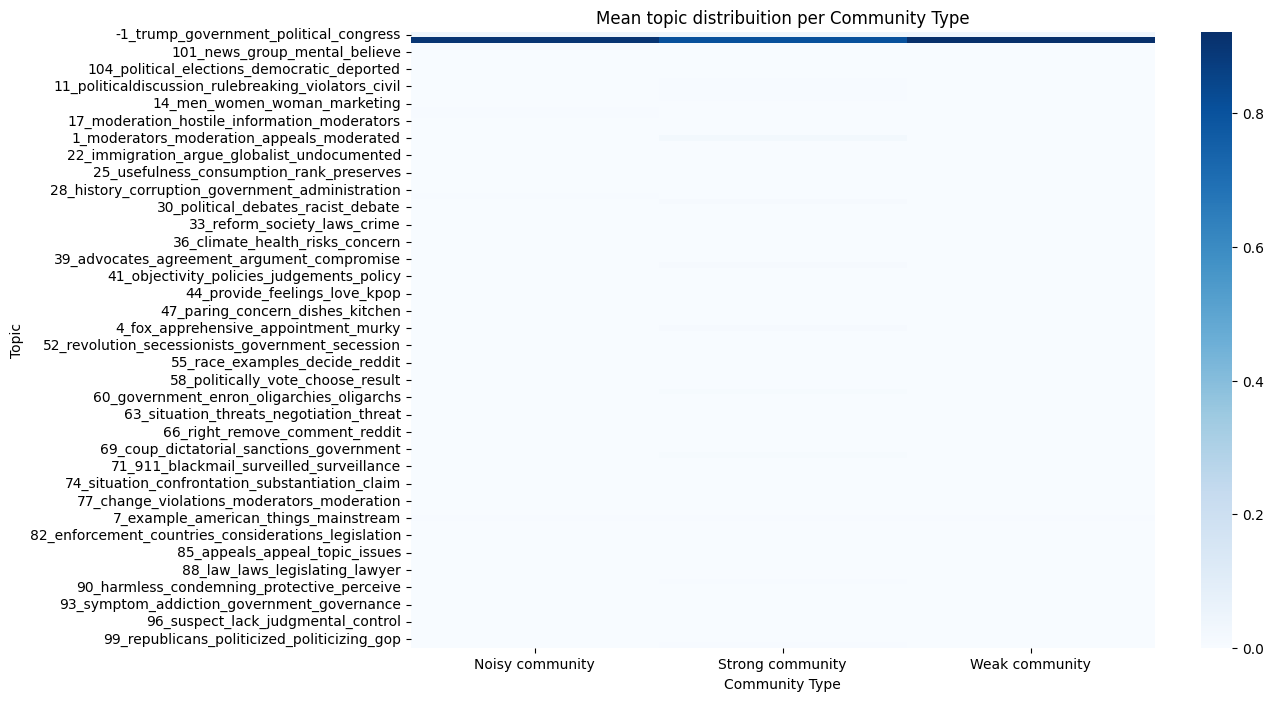

In [5]:
pivot = community_type_topics.pivot_table(
    index='topic',
    columns='community_type',
    values='percent',
    aggfunc='mean'
).fillna(0)

plt.figure(figsize=(12,8))
sns.heatmap(pivot, cmap="Blues")
plt.title("Mean topic distribuition per Community Type")
plt.ylabel("Topic")
plt.xlabel("Community Type")
plt.show()

/tmp/ipykernel_3857/1807640531.py:1: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top_topics = community_type_topics.groupby('community_type').apply(


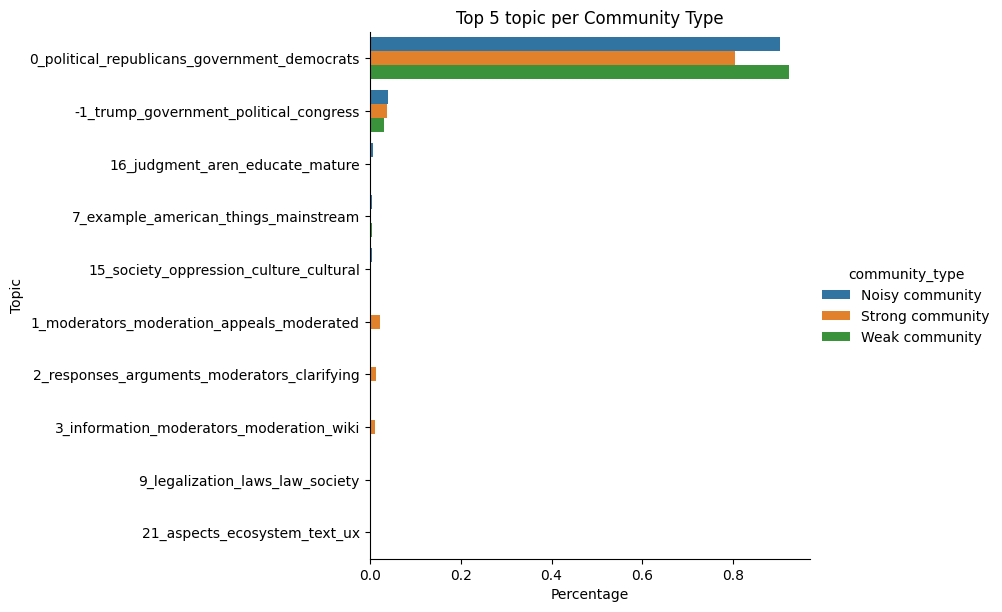

In [6]:
top_topics = community_type_topics.groupby('community_type').apply(
    lambda x: x.nlargest(5, 'percent')
).reset_index(drop=True)

sns.catplot(
    data=top_topics,
    kind="bar",
    x="percent", y="topic", hue="community_type",
    height=6, aspect=1.5
)
plt.title("Top 5 topic per Community Type")
plt.xlabel("Percentage")
plt.ylabel("Topic")
plt.show()
